# Chain

## Review

We built a simple graph with nodes, normal edges, and conditional edges.

### Goals

Now, let's build up to a simple chain that combines 4 concepts:

* Using chat messages as our graph state
* Using chat models in graph nodes
* Binding tools to our chat model
* Executing tool calls in graph nodes

## Messages

Chat models can use _messages_, which capture different roles within a conversation.

LangChain supports various message types, including _HumanMessage_, _AIMessage_, _SystemMessage_, and _ToolMessage_.

These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call.

Let's create a list of messages.

Each message can be supplied with a few things:

* _content_ - content of the message
* _name_ - optionally, a message author
* _response_metadata_ - optionally, a dict of metadata (e.g., often populated by model provider for AIMessages)

In [3]:
# import libraries
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


## Chat Models

Chat models can use a sequence of message as input and support message types, as discussed above.

There are many to choose from! Let's work with OpenAI.

In [4]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model_name = 'gpt-4o-mini')

In [5]:
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [6]:
result

AIMessage(content='One of the best places to see orcas in the U.S. is the Pacific Northwest, particularly around the waters of Washington State. Here are a few notable locations:\n\n1. **San Juan Islands**: This archipelago is famous for orca sightings, especially in the waters surrounding Orcas Island, San Juan Island, and Lopez Island. The best time to see orcas here is typically from late spring to early fall.\n\n2. **Seattle and the Puget Sound**: There are several whale-watching tours that operate out of Seattle, providing opportunities to see orcas in the nearby waters of the Puget Sound.\n\n3. **Victoria, British Columbia**: While technically in Canada, many tours from Seattle and the San Juan Islands include trips to Victoria, where orcas are often spotted.\n\n4. **Point Reyes National Seashore**: Located in Northern California, this area also offers opportunities to see orcas, particularly during their migratory periods.\n\n5. **Channel Islands National Park**: While not as co

In [8]:
result.response_metadata

{'token_usage': {'completion_tokens': 260,
  'prompt_tokens': 67,
  'total_tokens': 327,
  'completion_tokens_details': {'audio_tokens': 0,
   'reasoning_tokens': 0,
   'accepted_prediction_tokens': 0,
   'rejected_prediction_tokens': 0},
  'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
 'model_name': 'gpt-4o-mini-2024-07-18',
 'system_fingerprint': 'fp_f59a81427f',
 'finish_reason': 'stop',
 'logprobs': None}

# Tools

Tools are useful whenever you want a model to interact with external systems.

External systems (e.g., APIs) often require a particular input schema or payload, rather than natural language.

When we bind an API, for example, as a tool we given the model awareness of the required input schema.

The model will choose to call a tool based upon the natural language input from the user.

And, it will return an output that adheres to the tool's schema.

Many LLM providers support tool calling and tool calling interface in LangChain is simple.

You can simply pass any Python function into ChatModel.bind_tools(function)

<img src='https://camo.githubusercontent.com/9ccbea2be12f1cb8a31c62e10a2360c30f35879c7860d66626d6aac58f648e9d/68747470733a2f2f63646e2e70726f642e776562736974652d66696c65732e636f6d2f3635623863643732383335636565616364343434396135332f3636646261623038646331633137613761353766393936305f636861696e322e706e67'>

Let's showcase a simple example of tool calling!

The multiply function is our tool

In [13]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])

f we pass an input - e.g., "What is 2 multiplied by 3" - we see a tool call returned.

The tool call has specific arguments that match the input schema of our function along with the name of the function to call.

{'arguments': '{"a":2,"b":3}', 'name': 'multiply'}

In [14]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 20 multiplied by 10", name="Lance")])
tool_call

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_XyzGZO18UUnfgA7zsKmkj0Rh', 'function': {'arguments': '{"a":20,"b":10}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 62, 'total_tokens': 79, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0ba0d124f1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-47536cc2-5b9b-4667-81e0-7d5041c8be95-0', tool_calls=[{'name': 'multiply', 'args': {'a': 20, 'b': 10}, 'id': 'call_XyzGZO18UUnfgA7zsKmkj0Rh', 'type': 'tool_call'}], usage_metadata={'input_tokens': 62, 'output_tokens': 17, 'total_tokens': 79, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [15]:
tool_call.additional_kwargs['tool_calls']

[{'id': 'call_XyzGZO18UUnfgA7zsKmkj0Rh',
  'function': {'arguments': '{"a":20,"b":10}', 'name': 'multiply'},
  'type': 'function'}]

In [16]:
tool_call.response_metadata

{'token_usage': {'completion_tokens': 17,
  'prompt_tokens': 62,
  'total_tokens': 79,
  'completion_tokens_details': {'audio_tokens': 0,
   'reasoning_tokens': 0,
   'accepted_prediction_tokens': 0,
   'rejected_prediction_tokens': 0},
  'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
 'model_name': 'gpt-4o-mini-2024-07-18',
 'system_fingerprint': 'fp_0ba0d124f1',
 'finish_reason': 'tool_calls',
 'logprobs': None}

### Using messages as state

With these foundations in place, we can now use messages in our graph state.

Let's define our state, MessagesState, as a TypedDict with a single key: messages.

messages is simply a list of messages, as we defined above (e.g., HumanMessage, etc).

In [17]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

### Reducers

Now, we have a minor problem!

As we discussed, each node will return a new value for our state key messages.

But, this new value will will override the prior messages value.

As our graph runs, we want to append messages to to our messages state key.

We can use reducer functions address this.

Reducers allow us to specify how state updates are performed.

If no reducer function is specified, then it is assumed that updates to the key should override it as we saw before.

But, to append messages, we can use the pre-built add_messages reducer.

This ensures that any messages are appended to the existing list of messages.

We annotate simply need to annotate our messages key with the add_messages reducer function as metadata.

In [18]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

Since having a list of messages in graph state is so common, LangGraph has a pre-built MessagesState!

MessagesState is defined:

With a pre-build single messages key
This is a list of AnyMessage objects
It uses the add_messages reducer
We'll usually use MessagesState because it is less verbose than defining a custom TypedDict, as shown above.

In [19]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

To go a bit deeper, we can see how the add_messages reducer works in isolation.

In [20]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='1cda645a-442e-41a2-ba16-19efe7f60a7b'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='78274296-13f2-4fca-89d4-265fa943a6c7'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='ba2d002f-03a2-404e-bfc4-ae180ae425a0')]

### Our graph

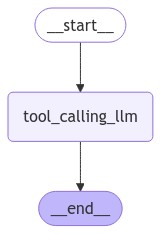

In [21]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
    
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

If we pass in Hello!, the LLM responds without any tool calls.

In [23]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hello! How can I assist you today?


The LLM chooses to use a tool when it determines that the input or task requires the functionality provided by that tool.

In [24]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_2HeyE74JUZMhWvdTI73gUh6l)
 Call ID: call_2HeyE74JUZMhWvdTI73gUh6l
  Args:
    a: 2
    b: 3
